<a href="https://colab.research.google.com/github/restrepo/ComputationalMethods/blob/master/material/least_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Least Action

Load modules

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import numpy as np
import scipy.optimize 
import pandas as pd
global g  
g=9.8

<div style="float: right;" markdown="1">
    <img src="https://raw.githubusercontent.com/restrepo/ComputationalMethods/master/material/figures/leastaction1.svg?sanitize=true">
</div>

## Geometry interpretation
Following the geometry theory developed [here](http://www.eftaylor.com/software/ActionApplets/LeastAction.html), we will try to define something called the _Action_ for one small segment of the free fall movement in one-dimension. 

For that we need the experimental data consisting on the height of an object of mass $m$ in free fall, and the height $x_i$, for each time $t_i$. This data would be fitted by a polynomial of degree two, as displayed in the figure for one of the fitted segments of the plot of $x$ as a function of $t$. We take the origin of the coordinates at ground level. For each segment we can calculate an average kinetic energy, $T$, and an averge potential energy, $V$, in the limit of $\Delta t=t_2-t_1$ small. From the figure

\begin{align}
T=\frac12 m v^2\approx &\frac12 m\left(\frac{x_2-x_1}{t_2-t_1}\right)^2\,,&
V=mgh\approx& m g \frac{x_2+x_1}{2}\,.
\end{align}

We can then reformulate the problem of the free fall in the following terms. From all the possible curves that can interpolate the points $(t_1,x_1)$ and $(t_2,x_2)$, which is the correct one?. 

The answer obtained by Leonhard Euler [1] can be obtained from the definition of the function "Lagrangian"
$$L(t)=T(t)-V(t)\,.$$

<div style="float: right;" markdown="1">
    <img src="https://raw.githubusercontent.com/restrepo/ComputationalMethods/master/material/figures/leastaction2.svg?sanitize=true">
</div>

With this, we can build the "Action", by integrating the Lagrangian function between the points $(t_1,x_1)$ and $(t_2,x_2)$ as
$$S=\int_{t_1}^{t_2} L\, \operatorname{d}t\,. $$

which give us a numerical result with units of energy multiplied by time (J$\cdot$s). What is worth noticing is that if we relax the definition of $V$ and allows for any $h$, but keeping the initial and final points fixed, we can calculate many Action values. This is illustrated in the figure for blue dotted ($S_1$), solid ($S_{\text{min}}$) and dashed ($S_2$)lines. But only the height, $(x_1+x_2)/2$ , associated with the real physical path, has a minimum value for the Action, $S_{\text{min}}$!

In fact, for one segment of the action between $(t_1,x_1)$, and $(t_2,x_2)$, with $\Delta t$ sufficiently small such that $L$ can be considered constant, we have
\begin{eqnarray}
S_{\text{min}}&=&\int_{t_1}^{t_2} L dt \\
&\approx& \left[\frac12 m v^2-m g h \right]\Delta t\\
&\approx& \left[\frac12 m\left(\frac{x_2-x_1}{t_2-t_1}\right)^2-m g \frac{x_2+x_1}{2} \right](t_2-t_1)
\end{eqnarray}
that corresponds to Eq. (11) of Am. J. Phys, Vol. 72(2004)478: http://www.eftaylor.com/pub/Symmetries&ConsLaws.pdf

<div style="float: right;" markdown="1">
    <img src="https://raw.githubusercontent.com/restrepo/ComputationalMethods/master/material/figures/leastaction3.svg?sanitize=true">
</div>

__Least Action method__: The least action method consist in the following steps illustrated in the figure
1. Fix the initial and final point of the movement. Example the initial time and the height from which a body is launched upwards, $(t_1,x_1)$, and the final time and height $(t_2,x_1)$.
1. Divide the problem in small segments of $\Delta t=t_{i+1}-t_i$.
1. Build many paths with the initial and final point fixed and calculates the Action in each segment, $S_i$, for all the paths
1. Choose the minimal Action for each segment, $S_{\text{min}}^i$, and rebuild the full path which minimizes the Action in each segment. This is the physical trajectory!



## Code implementation

### The Action
We define the Action $S$ such of an object of mass $m$ throw vertically upwards from $x_{\hbox{ini}}$, such that $t_{\hbox{end}}$ seconds later the object return to a height $x_{\hbox{end}}$, as
\begin{align}
S=&\int_{t_{\hbox{ini}}}^{t_{\hbox{end}}} L\, {\rm d}t \\
=& \sum_i S_i\\
=&\sum_i L_i \Delta t\,.
\end{align}

In [0]:
def S(x,tend=3.,m=0.2,xini=0.,xend=0.):
    """
    Calculate the Action of an object of of mass 'm' throw vertically upward from 
       'xini', such that 'tend' seconds later the object return to a height 'xend'.
       Delta t must be constant.
       
    The defaults units for S are J.s   
    """
    x=np.asarray(x)
    Dt=tend/x[:-1].size
    #Fix initial and final point
    x[0]=xini
    x[-1]=xend
    return ((0.5*m*(x[1:]-x[:-1])**2/Dt**2-0.5*m*g*(x[1:]+x[:-1]))*Dt).sum()

#### Example
Consider an object of mass $m=0.2~$Kg throw vertically upwards from an intial height of zero, and a flight time of $3~$s

1) Calculates the action for an intermediate set of points with $\Delta t=0.5$ s and _an arbitrary path_.
__Activity__: Change the path to any other value and report with the same initial and final values of zero and report the Action calculations by the chat

In [0]:
tini=0
tend=3
xini=0
xend=0

In [0]:
x=np.array([xini,10,15.,22.,18.,5.,xend])#.size

In [0]:
#Initial points: x_i
x[:-1]

array([ 0., 10., 15., 22., 18.,  5.])

In [0]:
#final points: x_{i+1}
x[1:]

array([10., 15., 22., 18.,  5.,  0.])

In [0]:
Δt=tend/x[:-1].size
Δt

0.5

In [0]:
t=[i*Δt for i in range(x.size) ]

In [0]:
t

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

In [0]:
df=pd.DataFrame({'t':t,'x':x})

In [0]:
df

,t,x
0,0.0,0.0
1,0.5,10.0
2,1.0,15.0
3,1.5,22.0
4,2.0,18.0
5,2.5,5.0
6,3.0,0.0


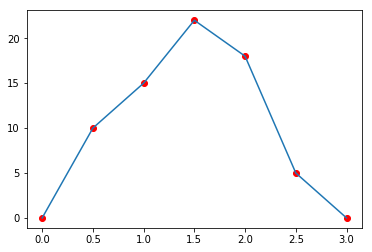

In [0]:
plt.plot(df.t,df.x,'ro')
plt.plot(df.t,df.x)

In [0]:
S(df.x) # J.s

8.199999999999996

2) Fit the points with a polynomial of degree 2 and calculates the Action for 20 points along the fitted curve but keeping the same initial and final points!

In [0]:
coeffs=np.polyfit(df.t,df.x,2)
P=np.poly1d(coeffs)
print(P)

        2
-8.905 x + 26.21 x - 0.381


In [0]:
t=np.linspace(0,3,20)

In [0]:
x=P(t)
x[0]=xini
x[-1]=xend
x

array([ 0.        ,  3.53614299,  7.00923361, 10.03831948, 12.62340061,
       14.76447698, 16.46154861, 17.71461549, 18.52367762, 18.888735  ,
       18.80978763, 18.28683551, 17.31987864, 15.90891703, 14.05395067,
       11.75497955,  9.01200369,  5.82502308,  2.19403773,  0.        ])

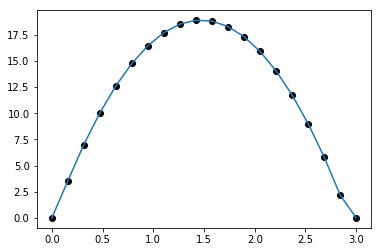

In [0]:
plt.plot(t,x,'ko')
plt.plot(t,x)

In [0]:
S(P(df.t))

-10.842970521541925

#### Exercise
Try to find a large action (larger than 10 J$\cdot$s) and the minimal possible action

### Solution to a free fall problem
\begin{align}
 x=&-\frac{1}{2} g t^2+v_0 t \,, & v=&-g t +v_0
\end{align}
At maximum height $t=t_{\text{end}}/2$ and
\begin{align}
 x_{\text{max}}=&-\frac{1}{2} g (t_{\text{end}}/2)^2+v_0 \frac{t_{\text{end}}}{2} \,, & 0=&-g \frac{t_{\text{end}}}{2} +v_0
\end{align}
From the second equation $v_0=g t_{\text{end}}/2=14.7$ m/s, and
\begin{align}
 x_{\text{max}}=&-\frac{1}{2} g (t_{\text{end}}/2)^2+ g \frac{t_{\text{end}}}{2} \frac{t_{\text{end}}}{2} \nonumber\\
 =&g\frac{ t_{\text{end}}^2  }{8}=11.025\ \text{m}\,.
\end{align}

__Activity__: Find the same solution by fitting the polynomial of degree 2 that go trough the points: 
* $(t_0,x_0)=(0,0)$,  
* $(t_{\rm end}/2,x_{\rm max})=(11.025,1.5)$, 
* $(t_{\rm end},x_{\rm end})=(0,3)$, in s and m respectively.

In [0]:
df=pd.DataFrame( {'t':[0,1.5,3],
                  'x':[0,11.025,0]
     })
df

,t,x
0,0.0,0.000
1,1.5,11.025
2,3.0,0.000


In [0]:
df.loc[1,'x']=11.025 
coeff=np.polyfit(df.t,df.x,deg=2)
x=np.poly1d(coeff,variable='t')
print(x)

      2
-4.9 t + 14.7 t + 8.205e-15


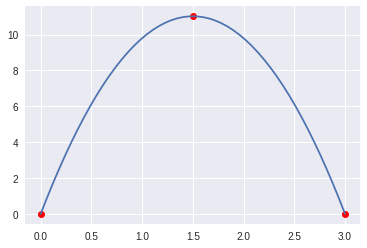

In [0]:
t=np.linspace(df.t.min(),df.t.max())
plt.plot(df.t,df.x,'ro')
plt.plot(t,x(t))
#plt.grid()

## Least Action for the free fall problem

<div style="float: right;" markdown="1">
    <img src="https://github.com/restrepo/ComputationalMethods/blob/master/material/figures/leastaction.png?raw=1">
</div>

### Geometry interpretation
Following the geometry theory developed [here](http://www.eftaylor.com/software/ActionApplets/LeastAction.html), we will try to define something called the _Action_ for one small segment of the free fall movement in one-dimension. 

For that we need the experimental data consisting on the height of an object of mass $m$ in free fall, and the height $x_i$, for each time $t_i$. This data would be fitted by a polynomial of degree two, as displayed in the figure for one of the fitted segments of the plot of $x$ as a function of $t$. We take the origin of the coordinates at ground level. For each segment we can calculate an average kinetic energy, $T$, and an averge potential energy, $V$, in the limit of $\Delta t=t_2-t_1$ small. From the figure

\begin{align}
T_{12}=\frac12 m v^2\approx &\frac12 m\left(\frac{x_2-x_1}{t_2-t_1}\right)^2\,,&
V_{12}=mgh\approx& m g \frac{x_2+x_1}{2}\,.
\end{align}

We can then reformulate the problem of the free fall in the following terms. From all the possible curves that can interpolate the points $(t_1,x_1)$ and $(t_2,x_2)$, which is the correct one?. 

The answer, found by Euler can be obtained from the definition of the function "Lagrangian"
$$L(t)=T(t)-V(t)$$

We define the "Action" of one interpolating function between the points $(t_1,x_1)$ and $(t_2,x_2)$ as
$$S=\int_{t_1}^{t_2} L\, {\rm d}t $$

The result is that the correct interpolation, called the _physical trajectory_, is the one which has a _minumum_ value for the Action!

For one segment of the action between $(t_1,x_1)$, and $(t_2,x_2)$, with $\Delta t$ sufficiently small such that $L$ can be considered constant, we have
\begin{eqnarray}
S_1&=&\int_{t_1}^{t_2} L dt \\
&\approx& \left[\frac12 m v^2-m g h \right]\Delta t\\
&\approx& \left[\frac12 m\left(\frac{x_2-x_1}{t_2-t_1}\right)^2-m g \frac{x_2+x_1}{2} \right](t_2-t_1)
\end{eqnarray}
that corresponds to Eq. (11) of Am. J. Phys, Vol. 72(2004)478: http://www.eftaylor.com/pub/Symmetries&ConsLaws.pdf

__Activity__: 
1. Calculates 
$$S=\int_{t_{\rm min}}^{t_{\rm max}} L(t)\operatorname{d}t $$
for the physical trajectory of a particle in free fall of $m=0.2\ $kg, where
$$L(t)=\frac{1}{2}m v^2(t)-mgx(t)$$
_Hint_:
$$F(t)=\int L(t)\operatorname{d}t$$
$$S=F(t_{\rm max})-F(t_{\rm min})$$
1. Calculates also the instataneous energy
$$E(t)=\frac{1}{2}m v^2(t)+mgx(t)$$
for  several times.

In [0]:
xmax=11.025 
df.loc[1,'x']=xmax
coeff=np.polyfit(df.t,df.x,deg=2)
x=np.poly1d(coeff,variable='t')
print('x(t) [m]:\n',x)
print("="*45)
m=0.2
g=9.8
v=x.deriv()
L=0.5*m*v**2-m*g*x
E=0.5*m*v**2+m*g*x
F=L.integ() # Analytical integration
S=F( df.t.max() ) - F( df.t.min() ) 
print('for xmax={} m: S={:.1f} J.s  min: -21.6 J.s'.format(xmax,S))
print("="*45)
Deltat=0.2
#t=np.linspace(df.t.min() , df.t.max(),10)
t=np.arange(df.t.min() , df.t.max()+Deltat,Deltat)
print('instantaneous energy [J]:\n {}'.format(E(t)))

x(t) [m]:
       2
-4.9 t + 14.7 t + 8.205e-15
for xmax=11.025 m: S=-21.6 J.s  min: -21.6 J.s
instantaneous energy [J]:
 [21.609 21.609 21.609 21.609 21.609 21.609 21.609 21.609 21.609 21.609
 21.609 21.609 21.609 21.609 21.609 21.609]


__Activity__: Changes the maximum height for the previous activity and check what happens with the instantaneous energy.

## Comparision with non-physical trajectories

---



I good approximation to the integral is:
$$S=\int_{t_{\rm min}}^{t_{\rm max}} L(t)\operatorname{d}t\approx \sum_i \left[\frac{L(t_{i+1})+L(t_i)}{2}\right]\Delta t$$

In [0]:
print('Δt={}'.format( t[1:]-t[:-1] )  )

Δt=[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]


In [0]:
print( 'S={:.1f} J.s'.format( 0.5*( L(t)[1:]+L(t)[:-1] ).sum()*Deltat ) )

S=-21.2 J.s


Or even more general

In [0]:
def Saprx(L,t):
    return   0.5*( L(t)[1:]+L(t)[:-1] )*(  t[1:]-t[:-1]  )  

print( 'S={:.1f} J.s'.format(  Saprx(L,t).sum() ) )

S=-21.2 J.s


S=-17.1  J.s
S=-21.6  J.s
S=-18.8  J.s


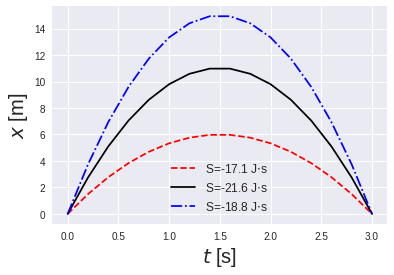

In [0]:
Ss=[]
Es=[]
m=0.2
g=9.8
Deltat=0.2
#t=np.linspace(df.t.min() , df.t.max(),10)
t=np.arange(df.t.min() , df.t.max()+Deltat,Deltat)
xmax=[6,11.025,15]; x0=0;xend=0
ls=['r--','k-','b-.']
for i in range(len(xmax) ):
    df=pd.DataFrame({'t':[t.min(),t.mean(),t.max()],'x':[x0,xmax[i],xend]})
    coeffs=np.polyfit(df.t,df.x,2)
    x=np.poly1d(coeffs,variable='t')
    v=x.deriv()
    L=0.5*m*v**2-m*g*x
    F=L.integ() # Analytical integration 
    E=0.5*m*v**2+m*g*x
    S=F( df.t.max() ) - F( df.t.min() )
    print('S={:.1f}  J.s'.format( S ) )
    Ss.append( Saprx(L,t)  )
    Es.append( E(t) )
    #Plot
    if ls:
        plt.plot(t,x(t),ls[i],label='S={:.1f} J$\cdot$s'.format( S  )   )

if ls:
    plt.legend(loc='best',fontsize=12)    
    plt.xlabel('$t$ [s]',size=20)
    plt.ylabel('$x$ [m]',size=20)

Only the physical trajectory conserves energy

In [0]:
Es

[array([ 6.4       ,  7.73404444,  8.87751111,  9.8304    , 10.59271111,
        11.16444444, 11.5456    , 11.73617778, 11.73617778, 11.5456    ,
        11.16444444, 10.59271111,  9.8304    ,  8.87751111,  7.73404444,
         6.4       ]),
 array([21.609, 21.609, 21.609, 21.609, 21.609, 21.609, 21.609, 21.609,
        21.609, 21.609, 21.609, 21.609, 21.609, 21.609, 21.609, 21.609]),
 array([40.        , 37.36177778, 35.10044444, 33.216     , 31.70844444,
        30.57777778, 29.824     , 29.44711111, 29.44711111, 29.824     ,
        30.57777778, 31.70844444, 33.216     , 35.10044444, 37.36177778,
        40.        ])]

Approximated result

In [0]:
Ss[0].sum(),Ss[1].sum(),Ss[2].sum()

(-16.958577777777823, -21.224840000000114, -18.1831111111111)

__Activity__: Check that the Action of a trajectory with a polynomial of order $n$ which fits $n+1$ points with the same extreme values, gives an Action that is larger than the previous minimun

In [0]:
df

,t,x
0,0.0,0
1,1.5,15
2,3.0,0


In [0]:
ndf=df.append({'t':0.75,'x':5},ignore_index=True)
ndf=ndf.append({'t':2.25,'x':2.7},ignore_index=True)
ndf=ndf.sort_values('t')
ndf

,t,x
0,0.00,0.0
3,0.75,5.0
1,1.50,15.0
4,2.25,2.7
2,3.00,0.0


S=-21.6  J.s


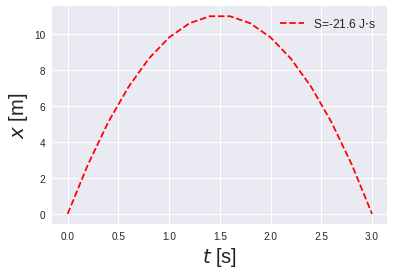

In [0]:
Ss=[]
Es=[]
m=0.2
g=9.8
Deltat=0.2
#t=np.linspace(df.t.min() , df.t.max(),10)
t=np.arange(df.t.min() , df.t.max()+Deltat,Deltat)
xmax=[11.025]; x0=0;xend=0
ls=['r--','k-','b-.']
for i in range(len(xmax) ):
    df=pd.DataFrame({'t':[t.min(),t.mean(),t.max()],'x':[x0,xmax[i],xend]})
    coeffs=np.polyfit(df.t,df.x,2)
    x=np.poly1d(coeffs,variable='t')
    v=x.deriv()
    L=0.5*m*v**2-m*g*x
    F=L.integ() # Analytical integration 
    E=0.5*m*v**2+m*g*x
    S=F( df.t.max() ) - F( df.t.min() )
    print('S={:.1f}  J.s'.format( S ) )
    Ss.append( Saprx(L,t)  )
    Es.append( E(t) )
    #Plot
    if ls:
        plt.plot(t,x(t),ls[i],label='S={:.1f} J$\cdot$s'.format( S  )   )

if ls:
    plt.legend(loc='best',fontsize=12)    
    plt.xlabel('$t$ [s]',size=20)
    plt.ylabel('$x$ [m]',size=20)
    


#### Solution
See `solution_least_action.ipynb`

### Solution with minimization
To be seen in Minimization

## References

[1] L. Euler, M´emoires de l'Acad´emie des Sciences de Berlin 4, 1898 (1748), republished in Ref.2, p. 38-63; L. Euler, M´emoires de l'Acad´emie des Sciences de Berlin 7, 169 (1751), republished in Ref. 2, p. 152. For a recent historical review see: Dias, Penha Maria Cardozo. (2017). Leonhard Euler's “principle of mechanics” (an essay on the foundations of the equations of motion). Revista Brasileira de Ensino de Física, 39(4), e4601. Epub May 22, 2017.https://doi.org/10.1590/1806-9126-rbef-2017-0057

[2] Leonhardi Euleri Opera Omnia, serie secunda, v. V, edited by J.O. Fleckenstein (Societatis Scientiarum Naturalium Helveticæ, Geneva,1957)
